In [80]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [81]:
# -- NEW ANALYZE FACES NOTEBOOK --
# 1. Detect valid frames (frames where we have searched faces)
#    Center frame the 80s is the frame where action t=0
# 2. Assign frames to an action
# 3. Create interesting dataframes as the following ones

In [121]:
detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/europe_uefa-champions-league/2016-2017/2017-03-08 - 22-45 Barcelona 6 - 1 Paris SG/face_detection_results_1_HQ.npy')
detections_path_2 = Path('../../../../mnt/DATA/datasets/soccernet/europe_uefa-champions-league/2016-2017/2017-03-08 - 22-45 Barcelona 6 - 1 Paris SG/face_detection_results_2_HQ.npy')
# detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_1_HQ.npy')
# detections_path_2 = Path('../../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_2_HQ.npy')
# detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/spain_laliga/2016-2017/2017-03-01 - 23-30 Real Madrid 3 - 3 Las Palmas/face_detection_results_1_HQ.npy')
# detections_path_2 = Path('../../../../mnt/DATA/datasets/soccernet/spain_laliga/2016-2017/2017-03-01 - 23-30 Real Madrid 3 - 3 Las Palmas/face_detection_results_2_HQ.npy')
detections1 = np.load(detections_path_1, allow_pickle=True)[0]
detections2 = np.load(detections_path_2, allow_pickle=True)[0]


In [122]:
count1=0
for frame_id in detections1.keys():
    if len(detections1[frame_id]) > 0:
        count1 += len(detections1[frame_id])
        
count2=0
for frame_id in detections2.keys():
    if len(detections2[frame_id]) > 0:
        count2 += len(detections2[frame_id])

In [123]:
count1 + count2

63867

In [124]:
from pathlib import Path
import json
import cv2

json_path = detections_path_1.parent.joinpath('Labels-v2.json')
with open(json_path) as f:
    data = json.load(f)
annotations = data['annotations']
for i in range(0, len(annotations)):
    if annotations[i]['gameTime'][0] == '2':
        index = i
        break
an1 = annotations[:index]
an2 = annotations[index:]
actions = [an1, an2]

In [126]:
def first_last_frame(frame_num, seconds_window, fs):
    first = max(frame_num - (seconds_window * fs), 1)
    last = (frame_num + (seconds_window * fs))
    return first, last

def get_frame(position, fs):
    return (position // 1000) * fs

def get_valid_frames_df(half, detections_path):
    frames_dir = detections_path.parent.joinpath(f'{half+1}_HQ','frames')
    seconds_window = 5
    fs = 8
    num_frames = len(list(frames_dir.glob('*.jpg')))

    valid_frames = set()
    for action in actions[half]:
        position = int(action['position'])
        frame_num = get_frame(position, fs)
        first_action_frame, last_action_frame = first_last_frame(frame_num, seconds_window, fs)
        for frame_id in range(first_action_frame, last_action_frame+1):
            valid_frames.add((f'{frame_id:05}', action['label'], first_action_frame, last_action_frame, int((first_action_frame+last_action_frame)/2)))

    invalid_frames = list(set(np.arange(num_frames)) - valid_frames)
    valid_frames = sorted(valid_frames)
    valid_frames_df = pd.DataFrame(valid_frames, columns=['frame','label','first','last','center'])
    
    return (valid_frames_df, valid_frames)
    
def get_faces_list_df(vf, detections):
    faces_list_df = pd.DataFrame(columns=['frame','face_id','info'])
    count = 0
    for key in vf:
        if len(detections[key[0]])>0:
            for face in detections[key[0]]:
                count += 1
                line = pd.DataFrame({'frame':[key[0]], 'face_id':[face], 'info':[detections[key[0]][face]['score']]})
                faces_list_df = pd.concat([faces_list_df, line], axis=0)
    # print(count)
    return faces_list_df

In [127]:
# 1st Half
valid_frames_df_1, valid_frames_1 = get_valid_frames_df(0, detections_path_1)
faces_list_df_1 = get_faces_list_df(valid_frames_1.copy(), detections1).drop_duplicates()
faces_info_df_1 = pd.merge(faces_list_df_1, valid_frames_df_1, on=['frame'], how='inner')


In [128]:
faces_diff_1 = faces_info_df_1.copy()
faces_diff_1['relative_frame'] = faces_diff_1['frame'].astype(int) - faces_diff_1['center']


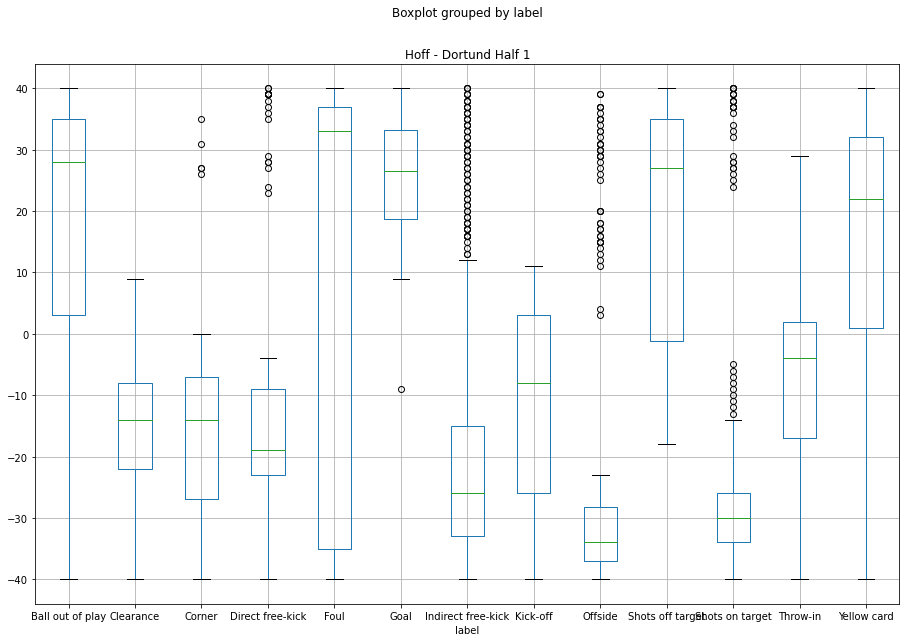

In [129]:
faces_diff_1.boxplot(column='relative_frame',by='label', figsize=(15,10))
plt.title('Hoff - Dortund Half 1')
plt.show()



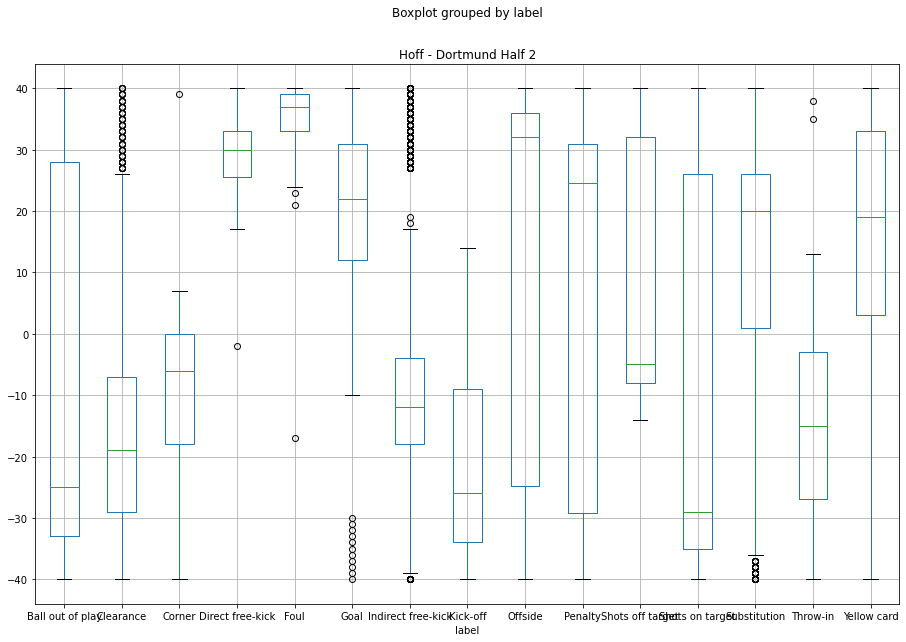

In [130]:
# 2nd Half
valid_frames_df_2, valid_frames_2 = get_valid_frames_df(1, detections_path_2)
faces_list_df_2 = get_faces_list_df(valid_frames_2, detections2).drop_duplicates()
faces_info_df_2 = pd.merge(faces_list_df_2, valid_frames_df_2, on=['frame'], how='inner')

faces_diff_2 = faces_info_df_2.copy()
faces_diff_2['relative_frame'] = faces_diff_2['frame'].astype(int) - faces_diff_2['center']

faces_diff_2.boxplot(column='relative_frame',by='label', figsize=(15,10))
plt.title('Hoff - Dortmund Half 2')
plt.show()


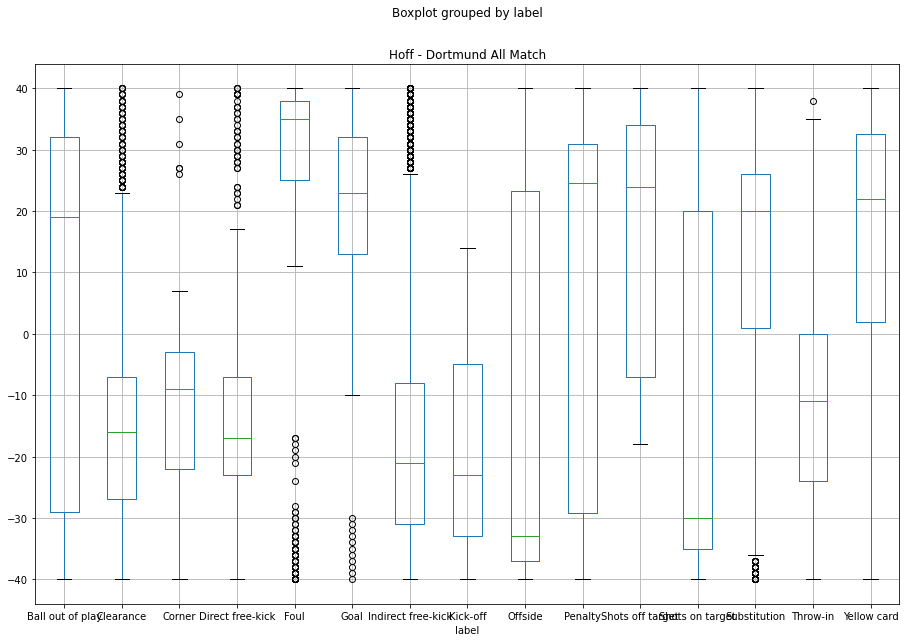

In [131]:
# All Match
faces_diff_1['half'] = 1
faces_diff_2['half'] = 2
faces_diff_all = pd.concat([faces_diff_1, faces_diff_2]).reset_index(drop=True)
faces_diff_all.boxplot(column='relative_frame',by='label', figsize=(15,10))
plt.title('Hoff - Dortmund All Match')
plt.show()

In [132]:
faces_info_df_1['half']=1
faces_info_df_2['half']=2
faces_info_df = pd.concat([faces_info_df_1, faces_info_df_2]).reset_index(drop=True)


actions_df = faces_info_df[['label','center','half']].drop_duplicates().drop(columns=['half','center'])
actions_df['actions count'] = 1
classes_count = actions_df.groupby(['label'], as_index=False).sum()

faces_action_count = faces_info_df[['frame','face_id','label','half']].drop_duplicates().drop(columns=['half'])
faces_action_count['faces count'] = 1
faces_action_count = faces_action_count.groupby(['label'], as_index=False).sum()


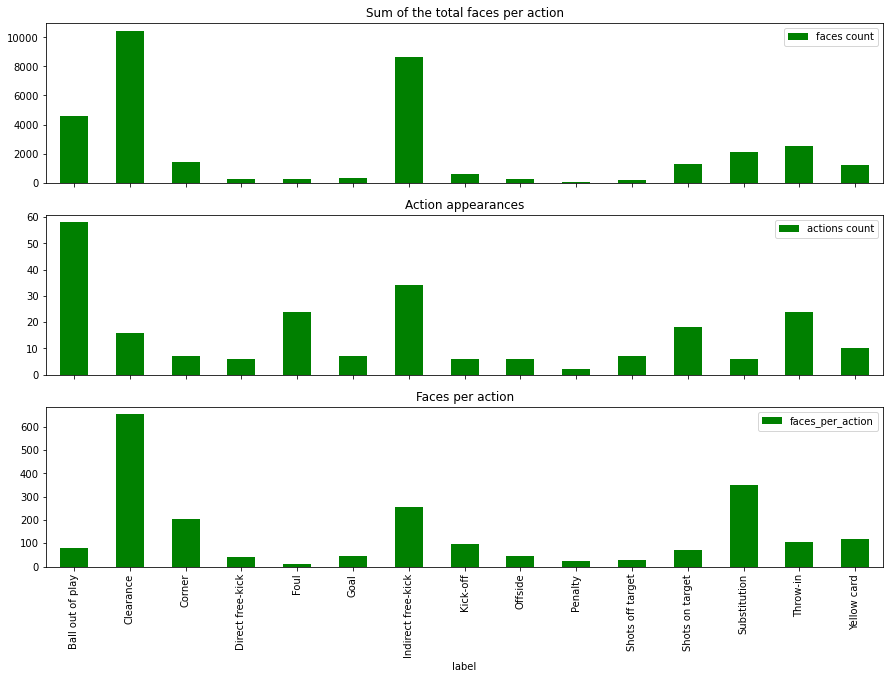

In [133]:
faces_per_action = pd.merge(faces_action_count, classes_count, on=['label'], how='inner')
faces_per_action['faces_per_action'] = faces_per_action['faces count'] // faces_per_action['actions count']

a = faces_per_action.copy()
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

a.plot(kind='bar',x='label',y='faces count',color='green', figsize=(15,15),
       title='Sum of the total faces per action', ax=axes[0])
a.plot(kind='bar',x='label',y='actions count',color='green', figsize=(15,15),
       title='Action appearances', ax=axes[1])
a.plot(kind='bar',x='label',y='faces_per_action',color='green', figsize=(15,10),
       title='Faces per action',ax=axes[2])
plt.show()
